# Practical Lesson on Climate Data Analysis 2
### Matteo Mastropierro and Davide Zanchettin

- see xarray tutorial repo at: https://github.com/xarray-contrib/xarray-tutorial.git

In [2]:
from google.colab import drive
drive.mount('/content/drive')

# Model - Observation BIAS

The CMCC-ESM2 model we are working with at is NOT a perfect representation of reality, because of the inherent missing physical representation of some processes. What we want to examine here is the deviation this model has from the (quasi-) observations of ERA5 reanalysis.

In [5]:
%%capture

%pip install cftime
%pip install cartopy

import cftime
import cartopy.crs as ccrs
import math

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import cftime
import warnings
warnings.filterwarnings('ignore')

#%matplotlib inline
#%config InlineBackend.figure_format='retina'

Load the historical ESM simulation

In [6]:
path = '/content/drive/MyDrive/Climate Data Analysis Lesson/'
file = 'tas_Amon_CMCC-ESM2_historical_r1i1p1f1_gn_185001-201412.nc'
ds_hist = xr.load_dataset(path+file)
ds_hist

<xarray.Dataset> Size: 438MB
Dimensions:    (time: 1980, bnds: 2, lat: 192, lon: 288)
Coordinates:
  * time       (time) object 16kB 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
  * lat        (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
    height     float64 8B 2.0
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object 32kB 1850-01-01 00:00:00 ... 2015-01-01 00...
    lat_bnds   (lat, bnds) float64 3kB -90.0 -89.53 -89.53 ... 89.53 89.53 90.0
    lon_bnds   (lon, bnds) float64 5kB -0.625 0.625 0.625 ... 358.1 358.1 359.4
    tas        (time, lat, lon) float32 438MB 250.6 251.8 250.5 ... 260.5 260.5
Attributes: (12/48)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  0.0
    comment:                none
    ...                     ...
    title:                  CMCC-ESM2 output prepared for CMIP6
    variable_id:            tas
    variant_label:          r1i1p1f1
    license:                CMIP6 model data produced by CMCC is licensed und...
    cmor_version:           3.6.0
    tracking_id:            hdl:21.14100/db148e8f-76e1-424c-92e0-8f5abb588c13

Load the ERA5 Reanalysis

In [7]:
file = 'tas_era5_mon_198001-201412.nc'
ds_rean = xr.load_dataset(path+file)
ds_rean

<xarray.Dataset> Size: 435MB
Dimensions:  (time: 420, lon: 720, lat: 360)
Coordinates:
  * time     (time) datetime64[ns] 3kB 1980-01-01 1980-02-01 ... 2014-12-01
  * lon      (lon) float64 6kB 0.0 0.5 1.0 1.5 2.0 ... 358.0 358.5 359.0 359.5
  * lat      (lat) float64 3kB -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
Data variables:
    t2m      (time, lat, lon) float32 435MB 243.7 243.7 243.7 ... 252.3 252.3
Attributes:
    CDI:          Climate Data Interface version 1.9.9rc1 (https://mpimet.mpg...
    Conventions:  CF-1.6
    history:      Wed Nov 27 11:18:27 2024: cdo -L -remapbil,r720x360 -selyea...
    CDO:          Climate Data Operators version 1.9.9rc1 (https://mpimet.mpg...

Look at the different configuration of the two Dataset. For ESM, our variable of interest is called `tas`, whereas for the reanalysis it is called `t2m`.

Coordinates are also named differently (eg `lat` vs `latitude`) and stored in a different order.

In [8]:
# Renaming variables

ds_rean = ds_rean.rename(t2m="tas")
ds_rean

<xarray.Dataset> Size: 435MB
Dimensions:  (time: 420, lon: 720, lat: 360)
Coordinates:
  * time     (time) datetime64[ns] 3kB 1980-01-01 1980-02-01 ... 2014-12-01
  * lon      (lon) float64 6kB 0.0 0.5 1.0 1.5 2.0 ... 358.0 358.5 359.0 359.5
  * lat      (lat) float64 3kB -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
Data variables:
    tas      (time, lat, lon) float32 435MB 243.7 243.7 243.7 ... 252.3 252.3
Attributes:
    CDI:          Climate Data Interface version 1.9.9rc1 (https://mpimet.mpg...
    Conventions:  CF-1.6
    history:      Wed Nov 27 11:18:27 2024: cdo -L -remapbil,r720x360 -selyea...
    CDO:          Climate Data Operators version 1.9.9rc1 (https://mpimet.mpg...

If we want to compare the two Datasets, what we need is them to have the same dimensions (Time, Lon and Lat)

In [9]:
# Here we show the resolution of both ESM and Reanalysis
# by looking at the difference among two longitudinal steps

display(ds_rean.lon[1] - ds_rean.lon[0])
display(ds_hist.lon[1] - ds_hist.lon[0])

<xarray.DataArray 'lon' ()> Size: 8B
array(0.5)

<xarray.DataArray 'lon' ()> Size: 8B
array(1.25)
Coordinates:
    height   float64 8B 2.0

In [10]:
# Here we show the resolution of both ESM and Reanalysis
# by looking at the difference among two latitudinal steps

display(ds_rean.lat[1] - ds_rean.lat[0])
display(ds_hist.lat[1] - ds_hist.lat[0])

<xarray.DataArray 'lat' ()> Size: 8B
array(0.5)

<xarray.DataArray 'lat' ()> Size: 8B
array(0.94240838)
Coordinates:
    height   float64 8B 2.0

In oder to get the same Spatial Resolution (Lat-Lon), we need to process our data through an interpolation algorithm, which allows us to have as a results a Dataset with the same number of Lon and Lat Coordinates (and thus the same resolution!)

In [11]:
ds_hist = ds_hist.sel(lat = slice(-85,85))
ds_rean = ds_rean.sel(lat = slice(-85,85))

In [12]:
new_lon = np.linspace(ds_hist.lon[0], ds_hist.lon[-1], ds_hist.dims["lon"])
new_lat = np.linspace(ds_hist.lat[0], ds_hist.lat[-1], ds_hist.dims["lat"])


In [13]:
ds_rean = ds_rean.interp(lat=new_lat, lon=new_lon)
display(ds_rean)

<xarray.Dataset> Size: 174MB
Dimensions:  (time: 420, lat: 180, lon: 288)
Coordinates:
  * time     (time) datetime64[ns] 3kB 1980-01-01 1980-02-01 ... 2014-12-01
  * lat      (lat) float64 1kB -84.35 -83.4 -82.46 -81.52 ... 82.46 83.4 84.35
  * lon      (lon) float64 2kB 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
Data variables:
    tas      (time, lat, lon) float64 174MB 245.7 245.5 245.4 ... 253.5 253.8
Attributes:
    CDI:          Climate Data Interface version 1.9.9rc1 (https://mpimet.mpg...
    Conventions:  CF-1.6
    history:      Wed Nov 27 11:18:27 2024: cdo -L -remapbil,r720x360 -selyea...
    CDO:          Climate Data Operators version 1.9.9rc1 (https://mpimet.mpg...

In [14]:
# Define Variable an convert Kelvin to Celsius

var = "tas"

ds_hist[var] = ds_hist[var] - 273.15
ds_rean[var] = ds_rean[var] - 273.15

Text(0.5, 0, 'K')

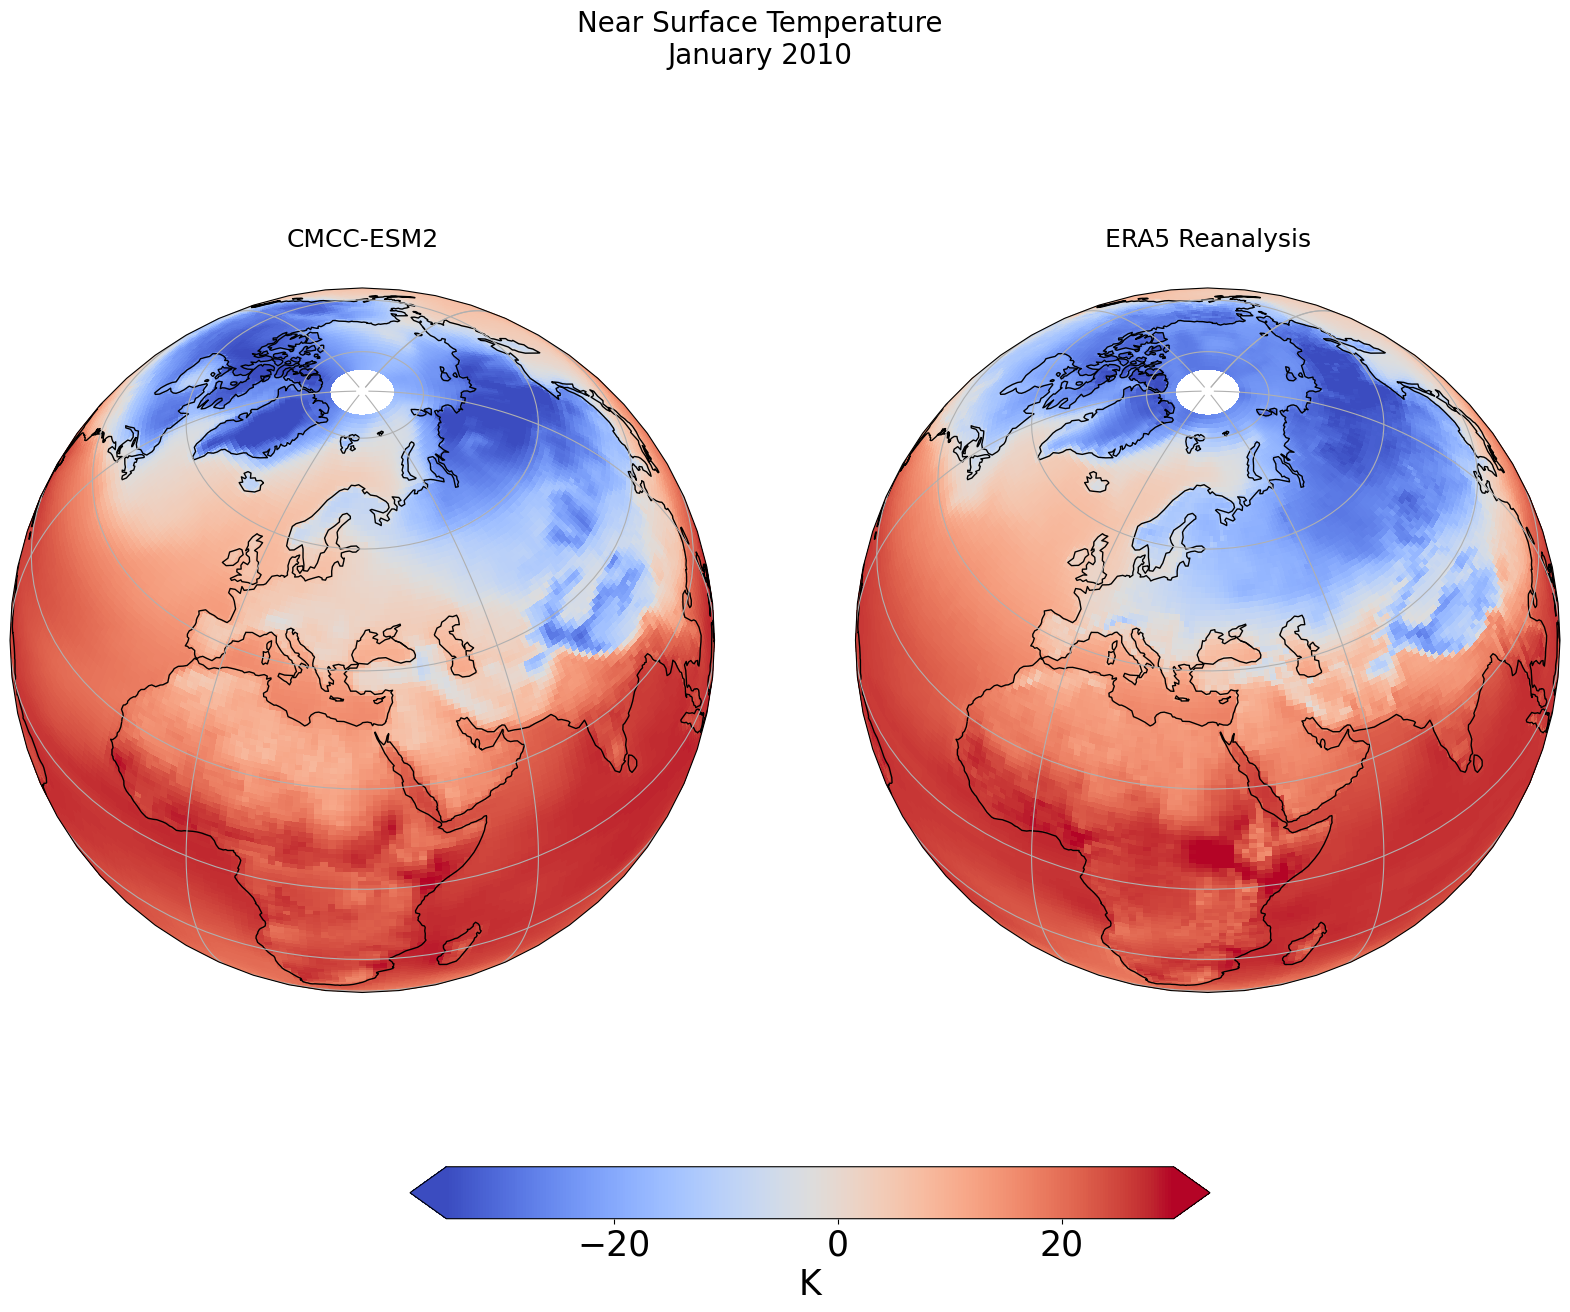

In [15]:
fig = plt.figure(1, figsize=[20,13])

# Set the projection to use for plotting
ax1 = plt.subplot(1, 2, 1, projection=ccrs.Orthographic(30, 45))
ax2 = plt.subplot(1, 2, 2, projection=ccrs.Orthographic(30, 45))

# Fix extent
minval = -35
maxval = 30

tsel = "2010-01"

map = ds_hist[var].sel(time=tsel).mean("time").plot(ax=ax1, vmin=minval, vmax=maxval,
                                           transform=ccrs.PlateCarree(),
                                           cmap='coolwarm',
                                           add_colorbar=False)

map = ds_rean[var].sel(time=tsel).mean("time").plot(ax=ax2, vmin=minval, vmax=maxval,
                                           transform=ccrs.PlateCarree(),
                                           cmap='coolwarm',
                                           add_colorbar=False)



ax1.set_title(ds_hist.attrs['parent_source_id'] , fontsize=18, pad = 30)
ax1.coastlines()
ax1.gridlines()

ax2.set_title("ERA5 Reanalysis" , fontsize=18, pad = 30)
ax2.coastlines()
ax2.gridlines()

# Title for both plots
fig.suptitle('Near Surface Temperature\n' + ds_hist[var].sel(time=tsel).time.values[0].strftime("%B %Y"), fontsize=20)


cb_ax = fig.add_axes([0.325, 0.05, 0.4, 0.04])

cbar = plt.colorbar(map, cax=cb_ax, extend='both', orientation='horizontal', fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=25)
cbar.ax.set_xlabel('K', fontsize=25)

Now we want to calculate the BIAS, so the deviation of the ESM from the quasi-observation of ERA5

In [16]:
# To compute the difference, we need not only Longitude and Latitude to have the same resolution
# but also the Dataarray need to have the same calendar

ds_hist.indexes['time']
ds_rean.indexes['time']

DatetimeIndex(['1980-01-01', '1980-02-01', '1980-03-01', '1980-04-01',
               '1980-05-01', '1980-06-01', '1980-07-01', '1980-08-01',
               '1980-09-01', '1980-10-01',
               ...
               '2014-03-01', '2014-04-01', '2014-05-01', '2014-06-01',
               '2014-07-01', '2014-08-01', '2014-09-01', '2014-10-01',
               '2014-11-01', '2014-12-01'],
              dtype='datetime64[ns]', name='time', length=420, freq=None)

In [17]:
# We can (luckily) easily convert our ESM cftime object to a standard datetime calendar

ds_hist['time'] = ds_hist.indexes['time'].to_datetimeindex()

In [18]:
# Let's compute the monthly bias
# Avoid lat to have different decimal approximations
ds_rean["lat"] = ds_hist["lat"]

bias = ds_hist.sel(time=slice("1985-01", "2012-12"))[var].groupby("time.month").mean() - ds_rean.sel(time=slice("1985-01", "2012-12"))[var].groupby("time.month").mean()

In [45]:
bias

<xarray.DataArray 'tas' (month: 12, lat: 180, lon: 288)> Size: 5MB
array([[[ 1.64889674e+01,  1.66940977e+01,  1.68836072e+01, ...,
          1.59889070e+01,  1.61066128e+01,  1.62901588e+01],
        [ 1.65941248e+01,  1.67351204e+01,  1.68765994e+01, ...,
          1.60792946e+01,  1.62728476e+01,  1.64288068e+01],
        [ 1.54238564e+01,  1.55769782e+01,  1.57365223e+01, ...,
          1.52806500e+01,  1.53040472e+01,  1.53362429e+01],
        ...,
        [ 1.77578706e+00,  1.76636712e+00,  1.89309015e+00, ...,
          1.38125712e+00,  1.40788316e+00,  1.48915636e+00],
        [ 1.54159925e+00,  1.64307328e+00,  1.83063771e+00, ...,
          1.18790185e+00,  1.32891273e+00,  1.56014794e+00],
        [ 1.50327769e+00,  1.64545661e+00,  1.72166372e+00, ...,
          1.35950020e+00,  1.48421933e+00,  1.41739397e+00]],

       [[ 8.03404438e+00,  8.25476594e+00,  8.41631052e+00, ...,
          7.56203812e+00,  7.68765286e+00,  7.84602315e+00],
        [ 7.90515559e+00,  8.06203348e+00,  8.25514758e+00, ...,
          7.20658530e+00,  7.47359527e+00,  7.67860772e+00],
        [ 6.92701231e+00,  7.09217065e+00,  7.28362882e+00, ...,
          6.96183646e+00,  6.90120320e+00,  6.89973894e+00],
...
        [ 1.29017980e+01,  1.27914284e+01,  1.27198947e+01, ...,
          1.28600837e+01,  1.28500867e+01,  1.28272513e+01],
        [ 1.32103924e+01,  1.31795545e+01,  1.31949351e+01, ...,
          1.31409008e+01,  1.31940700e+01,  1.32831634e+01],
        [ 1.34308371e+01,  1.34325425e+01,  1.33971132e+01, ...,
          1.34894616e+01,  1.35176018e+01,  1.34337364e+01]],

       [[ 1.30764638e+01,  1.33196065e+01,  1.34165801e+01, ...,
          1.27096464e+01,  1.27669990e+01,  1.28779556e+01],
        [ 1.35786331e+01,  1.36738726e+01,  1.37326310e+01, ...,
          1.32736144e+01,  1.34413434e+01,  1.34939170e+01],
        [ 1.27379153e+01,  1.28339086e+01,  1.29230645e+01, ...,
          1.27891203e+01,  1.27109665e+01,  1.26963668e+01],
        ...,
        [ 7.00109978e+00,  6.92451283e+00,  6.96604920e+00, ...,
          6.77596684e+00,  6.76966168e+00,  6.80250334e+00],
        [ 7.02236872e+00,  7.03408503e+00,  7.10957152e+00, ...,
          6.92026798e+00,  6.99273425e+00,  7.11189207e+00],
        [ 7.21322395e+00,  7.25525065e+00,  7.24929960e+00, ...,
          7.23987411e+00,  7.29118245e+00,  7.19961694e+00]]])
Coordinates:
  * lat      (lat) float64 1kB -84.35 -83.4 -82.46 -81.52 ... 82.46 83.4 84.35
  * lon      (lon) float64 2kB 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    height   float64 8B 2.0
  * month    (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12

Text(0.5, 0, 'K')

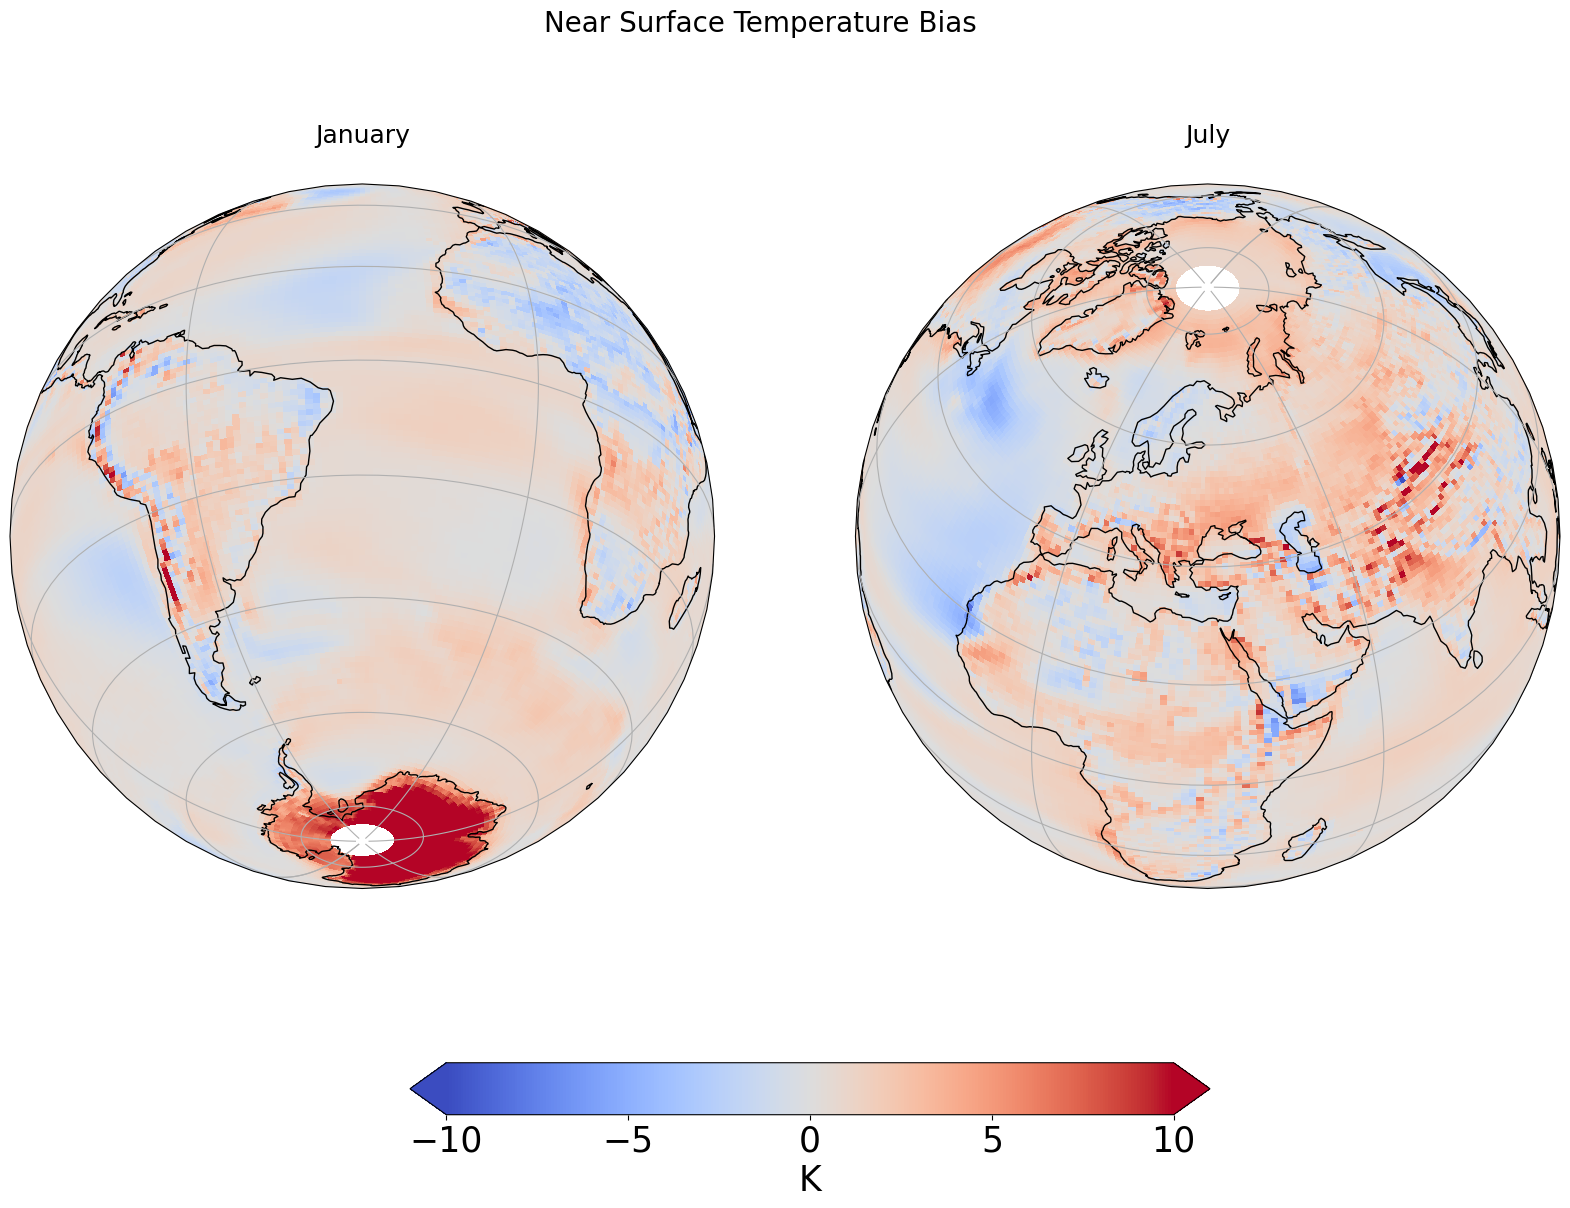

In [19]:
fig = plt.figure(1, figsize=[20,13])

# Set the projection to use for plotting
ax1 = plt.subplot(1, 2, 1, projection=ccrs.Orthographic(-30, -30))
ax2 = plt.subplot(1, 2, 2, projection=ccrs.Orthographic(30, 45))

# Fix MIN and MAX colorbar extent
minval = -10
maxval = 10

map = bias.sel(month =1).plot(ax=ax1, vmin=minval, vmax=maxval,
                                           transform=ccrs.PlateCarree(),
                                           cmap='coolwarm',
                                           add_colorbar=False)

map = bias.sel(month = 8).plot(ax=ax2, vmin=minval, vmax=maxval,
                                           transform=ccrs.PlateCarree(),
                                           cmap='coolwarm',
                                           add_colorbar=False)



ax1.set_title("January" , fontsize=18, pad = 30)
ax1.coastlines()
ax1.gridlines()

ax2.set_title("July" , fontsize=18, pad = 30)
ax2.coastlines()
ax2.gridlines()

# Title for both plots
fig.suptitle('Near Surface Temperature Bias', fontsize=20, y = 0.9)


cb_ax = fig.add_axes([0.325, 0.05, 0.4, 0.04])

cbar = plt.colorbar(map, cax=cb_ax, extend='both', orientation='horizontal', fraction=0.046)
cbar.ax.tick_params(labelsize=25)
cbar.ax.set_xlabel('K', fontsize=25)

# Historical - SSP245 scenario

Now, let's take a look at what the temperature could look like in a medium increase warming scenario, the SSP245.

In [20]:
# Import SSP245 and convert from Kelvin to Celsius

file = 'tas_Amon_CMCC-ESM2_ssp245_r1i1p1f1_gn_201501-210012.nc'
ds_ssp = xr.load_dataset(path+file)
ds_ssp[var].data = ds_ssp[var].data - 273.15
ds_ssp['time'] = ds_ssp.indexes['time'].to_datetimeindex()
ds_ssp

<xarray.Dataset> Size: 228MB
Dimensions:    (time: 1032, bnds: 2, lat: 192, lon: 288)
Coordinates:
  * time       (time) datetime64[ns] 8kB 2015-01-16T12:00:00 ... 2100-12-16T1...
  * lat        (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
    height     float64 8B 2.0
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object 17kB 2015-01-01 00:00:00 ... 2101-01-01 00...
    lat_bnds   (lat, bnds) float64 3kB -90.0 -89.53 -89.53 ... 89.53 89.53 90.0
    lon_bnds   (lon, bnds) float64 5kB -0.625 0.625 0.625 ... 358.1 358.1 359.4
    tas        (time, lat, lon) float32 228MB -19.72 -19.55 ... 0.5884 0.5883
Attributes: (12/48)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            ScenarioMIP
    branch_method:          standard
    branch_time_in_child:   60225.0
    branch_time_in_parent:  60225.0
    comment:                none
    ...                     ...
    title:                  CMCC-ESM2 output prepared for CMIP6
    variable_id:            tas
    variant_label:          r1i1p1f1
    license:                CMIP6 model data produced by CMCC is licensed und...
    cmor_version:           3.6.0
    tracking_id:            hdl:21.14100/90a9919e-6c68-4b66-98a7-4382e9f799b3

We can take the end of the century climatology (2070-2100) of the SSP245 dataset and compare it with the historical climatology (1980-2010) from the CMCC-ESM2 model.

This step is analogous to the bias calculation we have performed before, but now we are confronting the same model but two different time periods!

In [21]:
ds_diff = ds_ssp.sel(time=slice("2070-01", "2099-12"))[var].groupby("time.season").mean() - ds_hist.sel(time=slice("1980-01", "2009-12"))[var].groupby("time.season").mean()
ds_diff

<xarray.DataArray 'tas' (season: 4, lat: 180, lon: 288)> Size: 829kB
array([[[ 2.3809958,  2.351202 ,  2.3948421, ...,  2.4138288,
          2.405323 ,  2.4264212],
        [ 2.2244864,  2.2369843,  2.254241 , ...,  2.1860666,
          2.2082567,  2.1932192],
        [ 2.2094097,  2.2365923,  2.2348251, ...,  2.1458397,
          2.191966 ,  2.2164125],
        ...,
        [18.625885 , 18.546932 , 18.438066 , ..., 19.070408 ,
         18.961258 , 18.847324 ],
        [19.195253 , 19.10067  , 18.957771 , ..., 19.615026 ,
         19.461891 , 19.258316 ],
        [19.646461 , 19.505497 , 19.407055 , ..., 19.891737 ,
         19.755901 , 19.744793 ]],

       [[ 3.604473 ,  3.6386871,  3.6750603, ...,  3.504467 ,
          3.5366096,  3.5676155],
        [ 4.0286484,  3.9983635,  3.9796562, ...,  4.137165 ,
          4.106617 ,  4.06472  ],
        [ 3.7255592,  3.6943626,  3.6910477, ...,  3.9142952,
          3.849018 ,  3.7860947],
...
        [13.819676 , 13.826882 , 13.881403 , ..., 13.780801 ,
         13.772633 , 13.795666 ],
        [13.92342  , 13.913993 , 13.887583 , ..., 14.010763 ,
         13.983928 , 13.9388075],
        [14.056202 , 14.009859 , 13.975584 , ..., 14.1393585,
         14.090905 , 14.087344 ]],

       [[ 2.4918365,  2.477417 ,  2.5984306, ...,  2.561245 ,
          2.5433197,  2.6438026],
        [ 2.697033 ,  2.6566315,  2.6874466, ...,  2.762848 ,
          2.7443352,  2.7208443],
        [ 2.5175705,  2.479473 ,  2.4663963, ...,  2.5594215,
          2.6095238,  2.5384827],
        ...,
        [ 5.927    ,  5.9473724,  6.0138555, ...,  5.8435473,
          5.8400755,  5.871294 ],
        [ 5.824855 ,  5.8462453,  5.873291 , ...,  5.8093414,
          5.813198 ,  5.821603 ],
        [ 5.8066607,  5.816675 ,  5.825131 , ...,  5.8070374,
          5.8004723,  5.799987 ]]], dtype=float32)
Coordinates:
  * lat      (lat) float64 1kB -84.35 -83.4 -82.46 -81.52 ... 82.46 83.4 84.35
  * lon      (lon) float64 2kB 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * season   (season) object 32B 'DJF' 'JJA' 'MAM' 'SON'
    height   float64 8B 2.0

Let's visualize the expected warming by the end of the century, for both Winter and Summer seasons

Text(0.5, 0, '°C')

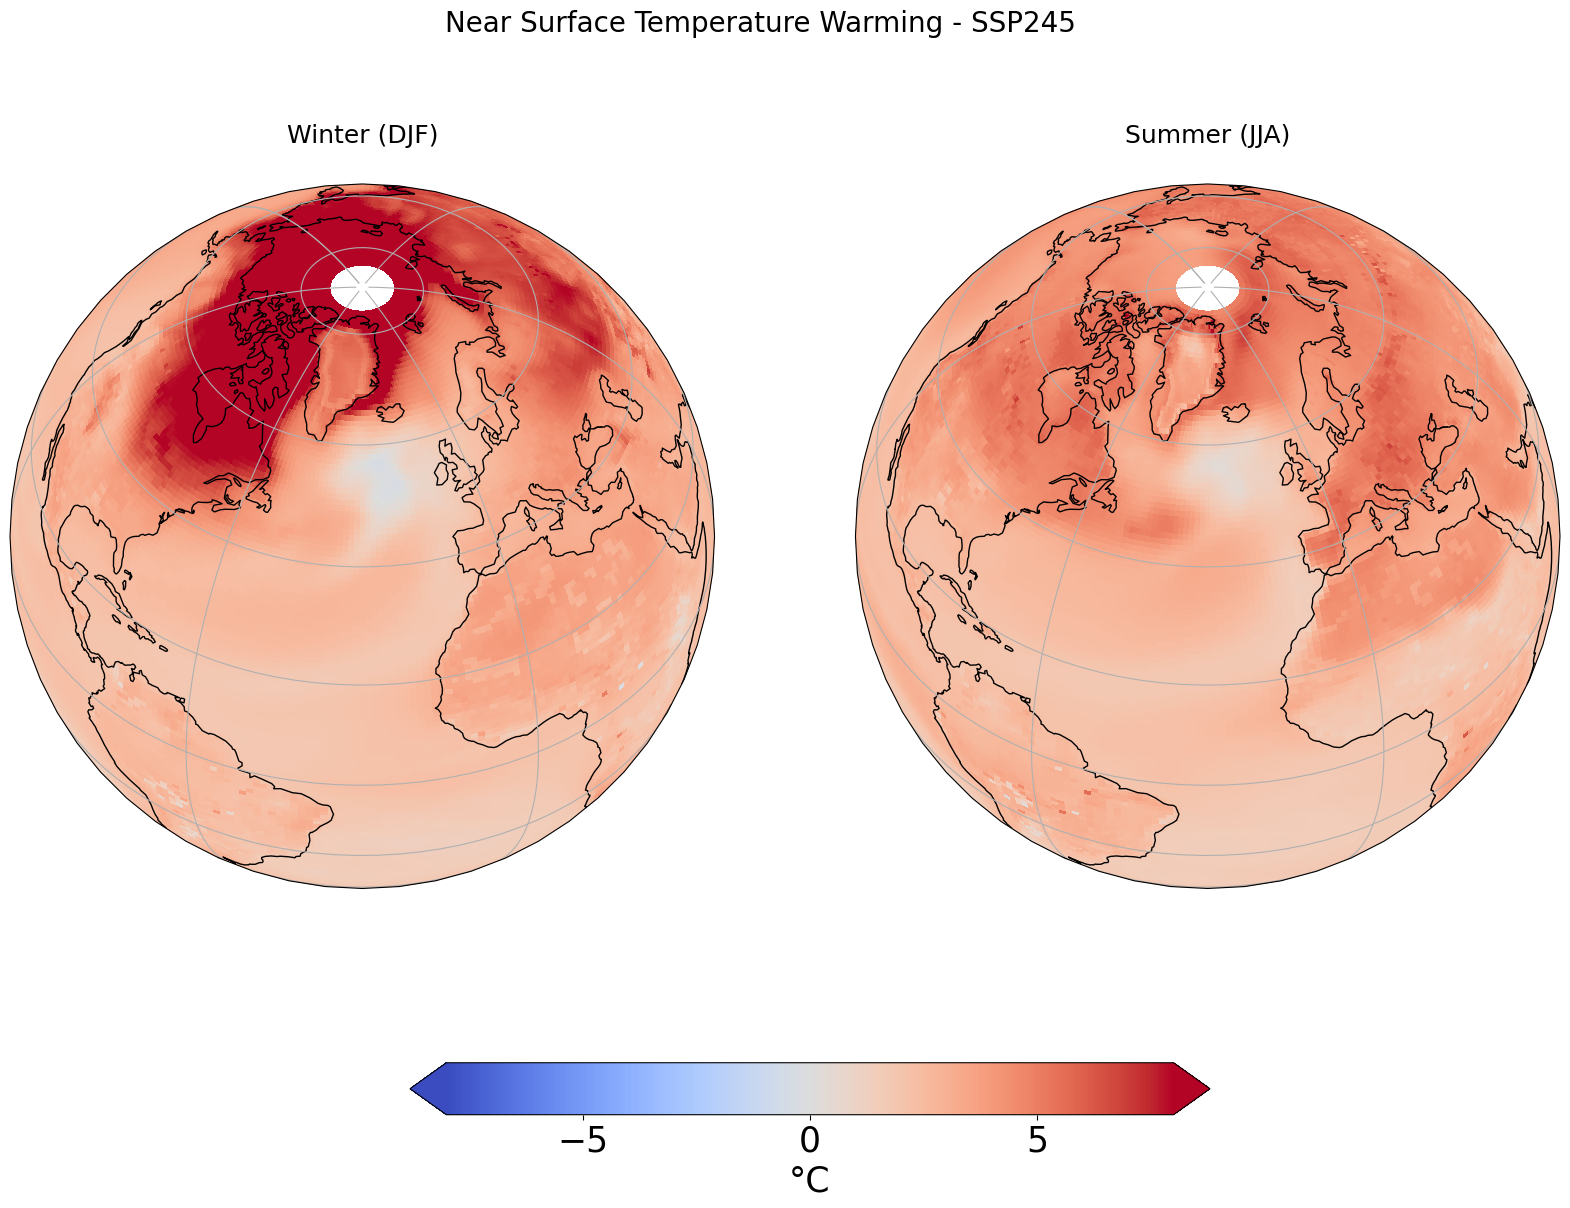

In [22]:
fig = plt.figure(1, figsize=[20,13])

# Set the projection to use for plotting
ax1 = plt.subplot(1, 2, 1, projection=ccrs.Orthographic(-30, 45))
ax2 = plt.subplot(1, 2, 2, projection=ccrs.Orthographic(-30, 45))

# Fix MIN and MAX colorbar extent
minval = -8
maxval = 8

map = ds_diff.sel(season = 'DJF').plot(ax=ax1, vmin=minval, vmax=maxval,
                                           transform=ccrs.PlateCarree(),
                                           cmap='coolwarm',
                                           add_colorbar=False)

map = ds_diff.sel(season = 'JJA').plot(ax=ax2, vmin=minval, vmax=maxval,
                                           transform=ccrs.PlateCarree(),
                                           cmap='coolwarm',
                                           add_colorbar=False)



ax1.set_title("Winter (DJF)" , fontsize=18, pad = 30)
ax1.coastlines()
ax1.gridlines()

ax2.set_title("Summer (JJA)" , fontsize=18, pad = 30)
ax2.coastlines()
ax2.gridlines()

# Title for both plots
fig.suptitle('Near Surface Temperature Warming - SSP245', fontsize=20, y = 0.9)


cb_ax = fig.add_axes([0.325, 0.05, 0.4, 0.04])

cbar = plt.colorbar(map, cax=cb_ax, extend='both', orientation='horizontal', fraction=0.046)
cbar.ax.tick_params(labelsize=25)
cbar.ax.set_xlabel('°C', fontsize=25)

The global mean warming trend it's clear, both in the Winter Season and in the SUmmer Season. Can you guess why the Arctic region it's so affected by global warming?

Try to change the Summer map projection center to Longitude -30 and Latitude 45 (line 5, ax2 = xxxxx)...What do you notice?

### Comparing two models projections

Several models provide simulation results for both historical period and future scenarios. Since every model has been developed in a slightly different way compared to the others, we can expect some differences in their temperature response to climate change.

We therefore now take  look at the temperature projections from an Australian model (ACCESS-ESM1-5) and compare them with the CMCC-ESM2, for the scenario SSP2-4.5

In [23]:
file = 'tas_Amon_ACCESS-ESM1-5_historical_r1i1p1f1_gn_185001-201412.nc'
ds_hist2 = xr.load_dataset(path+file)
ds_hist2[var].data = ds_hist2[var].data - 273.15
ds_hist2['time'] = ds_hist2.indexes['time'] #.to_datetimeindex()


In [24]:
# Import historical & SSP245 and convert from Kelvin to Celsius

file = 'tas_Amon_ACCESS-ESM1-5_ssp245_r1i1p1f1_gn_201501-210012.nc'
ds_ssp2 = xr.load_dataset(path+file)
ds_ssp2[var].data = ds_ssp2[var].data - 273.15
ds_ssp2['time'] = ds_ssp2.indexes['time'] #.to_datetimeindex()


### Mean Temperature trends throughout the 21st century

First, concatenate together the historical and future DataArrays (ds_hist & ds_ssp) along the `time` dimension

In [25]:
ds_all = xr.concat([ds_hist, ds_ssp], dim = "time")
ds_all = ds_all.drop(["time_bnds","lat_bnds","lon_bnds"])
ds_all[var] = ds_all[var]

In [26]:
ds_all2 = xr.concat([ds_hist2, ds_ssp2], dim = "time")
ds_all2 = ds_all2.drop(["time_bnds","lat_bnds","lon_bnds"])
ds_all2[var] = ds_all2[var]

Then, compute the mean along the `Lon` and `Lat` dimensions to get spatial average values, note that we need to weight our cell values according to their area (which varies with ``Latitude``).

Consider that the Area of a spherical pixel (with limited Longitude and Latitude) is:

$A = R^2 (\lambda_2 - \lambda_1) \left( \sin(\phi_2) - \sin(\phi_1) \right)$

Where $R$ is the radius of the sphere, and $\lambda$ and $\phi$ are expressed in radians.

In [27]:
def get_cell_area(ds):
    """Calculate the area of each pixel in m^2 given latitudes and longitudes."""
    lat = ds.lat.values
    lon = ds.lon.values
    # Earth radius in meters
    R = 6.371e6
    rad = (2 * math.pi / 360)  # Convert degrees to radians

    # Reshape lat and lon to make sure they have the correct shape
    if lat[0] > lat[-1]:
        lat = lat[::-1]

    # Calculate the area of each pixel cell
    pixel_areas = np.zeros((len(lat) - 1, len(lon) - 1))
    for i in range(len(lat) - 1):
        for j in range(len(lon) - 1):
            pixel_areas[i, j] = (R ** 2 *
                                 (math.sin(rad * lat[i + 1]) - math.sin(rad * lat[i])) *
                                 abs(lon[j + 1] - lon[j]) * rad)

    pixel_areas = xr.DataArray(pixel_areas, coords=[lat[:-1], lon[:-1]], dims=["lat", "lon"])
    return pixel_areas

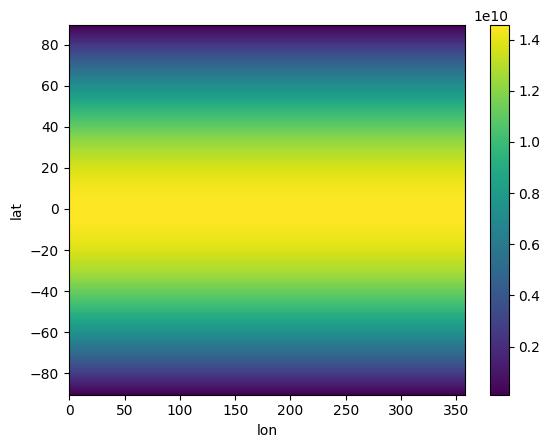

In [28]:
get_cell_area(ds_all).plot()

Text(0, 0.5, 'Temperature [°C]')

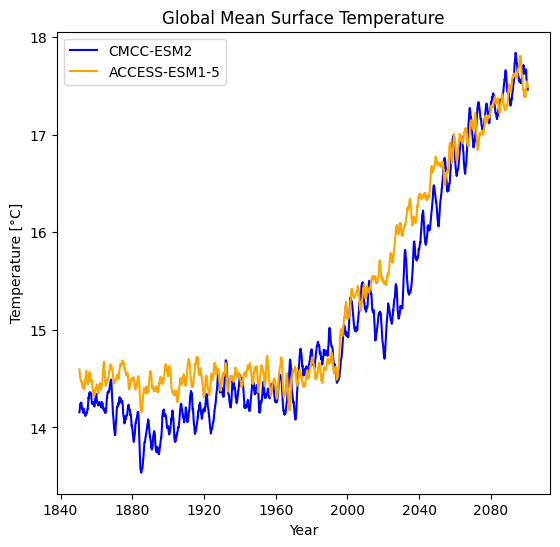

In [29]:
#Take a look at the Mean Global Temperature Trend

cell_area = get_cell_area(ds_all)
cell_area2 = get_cell_area(ds_all2)

fig = plt.figure(1, figsize=[14,6])

ax1 = plt.subplot(1,2,1)

ax1.plot(ds_all.time, ds_all.tas.weighted(cell_area).mean(dim = ["lat", "lon"]).rolling(time = 12, center = True).mean(), color = "blue")
ax1.plot(ds_all2.time, ds_all2.tas.weighted(cell_area2).mean(dim = ["lat", "lon"]).rolling(time = 12, center = True).mean(), color = "orange")

ax1.legend(["CMCC-ESM2", "ACCESS-ESM1-5"])

ax1.set_title("Global Mean Surface Temperature")
ax1.set_xlabel("Year")
ax1.set_ylabel("Temperature [°C]")

We want to compute the Global Warming Trend since the Preindustrial period (1850-1900), thus we need to Normalize our time-series for the 1850-1900 climatological mean and standard deviation

Text(0, 0.5, 'Temperature [°C]')

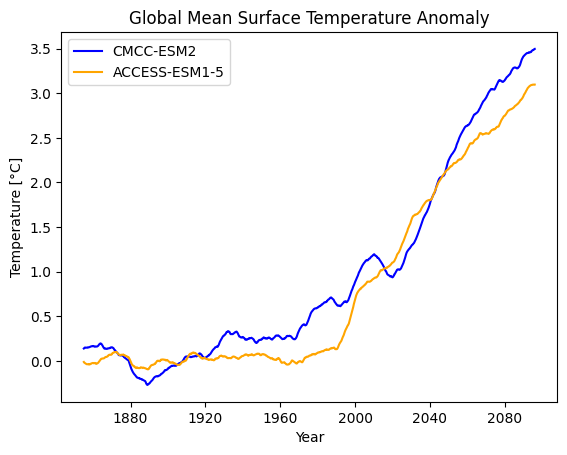

In [30]:
# Process CMCC-ESM2
ds_globe = ds_all.copy()

ds_globe = ds_globe.weighted(cell_area).mean(dim = ["lat", "lon"])
ds_globe = (ds_globe - ds_globe.sel(time = slice("1850-01","1899-12")).mean()) #/ds_globe.sel(time = slice("1850-01","1899-12")).std()
ds_globe = ds_globe.rolling(time = 120, center = True).mean()

# Process ACCESS-ESM1-5
ds_globe2 = ds_all2.copy()
ds_globe2 = ds_globe2.weighted(cell_area2).mean(dim = ["lat", "lon"])
ds_globe2 = (ds_globe2 - ds_globe2.sel(time = slice("1850-01","1899-12")).mean())# /ds_globe2.sel(time = slice("1850-01","1899-12")).std()
ds_globe2 = ds_globe2.rolling(time = 120, center = True).mean()

plt.plot(ds_globe["time"], ds_globe[var], color = "blue")
plt.plot(ds_globe2["time"], ds_globe2[var], color = "orange")

plt.legend(["CMCC-ESM2","ACCESS-ESM1-5"])

plt.title("Global Mean Surface Temperature Anomaly")
plt.xlabel("Year")
plt.ylabel("Temperature [°C]")


Compute the same for the Mediterranean Region: `Lon`=(-10, 43), `Lat`=(25, 48)

We need here to roll the longitude values from 0,360 to -180, 180

In [31]:
## Process CMCC-ESM2

ds_med = ds_all.copy()
# Roll the coordinates
ds_med.coords['lon'] = (ds_med.coords['lon'] + 180) % 360 - 180
ds_med = ds_med.sortby(ds_med.lon)
ds_art = ds_med.copy()
# MEDITERRANEAN REGIOn
ds_med = ds_med.sel(lon=slice(-10,43),lat=slice(25,48))
cell_area = get_cell_area(ds_med)
ds_med = ds_med.weighted(cell_area).mean(dim = ["lat", "lon"])
ds_med = (ds_med - ds_med.sel(time = slice("1850-01","1899-12")).mean())#/ds_med.sel(time = slice("1850-01","1899-12")).std()
ds_med = ds_med.rolling(time = 120, center = True).mean()
# ARCTIC REGION
ds_art = ds_art.sel(lat=slice(25,48))
cell_area = get_cell_area(ds_art)
ds_art = ds_art.weighted(cell_area).mean(dim = ["lat", "lon"])
ds_art = (ds_art - ds_art.sel(time = slice("1850-01","1899-12")).mean())#/ds_art.sel(time = slice("1850-01","1899-12")).std()
ds_art = ds_art.rolling(time = 120, center = True).mean()

## Process ACCESS-ESM1-5
ds_med2 = ds_all2.copy()
# Roll the coordinates
ds_med2.coords['lon'] = (ds_med2.coords['lon'] + 180) % 360 - 180
ds_med2 = ds_med2.sortby(ds_med2.lon)
ds_art2 = ds_med2.copy()
# MEDITERRANEAN REGIOn
ds_med2 = ds_med2.sel(lon=slice(-10,43),lat=slice(25,48))
cell_area = get_cell_area(ds_med2)
ds_med2 = ds_med2.weighted(cell_area).mean(dim = ["lat", "lon"])
ds_med2 = (ds_med2 - ds_med2.sel(time = slice("1850-01","1899-12")).mean())#/ds_med2.sel(time = slice("1850-01","1899-12")).std()
ds_med2 = ds_med2.rolling(time = 120, center = True).mean()
# ARCTIC REGION
ds_art2 = ds_art2.sel(lat=slice(25,48))
cell_area = get_cell_area(ds_art2)
ds_art2 = ds_art2.weighted(cell_area).mean(dim = ["lat", "lon"])
ds_art2 = (ds_art2 - ds_art2.sel(time = slice("1850-01","1899-12")).mean())#/ds_art2.sel(time = slice("1850-01","1899-12")).std()
ds_art2 = ds_art2.rolling(time = 120, center = True).mean()


Text(0.5, 1.0, 'ARTIC region')

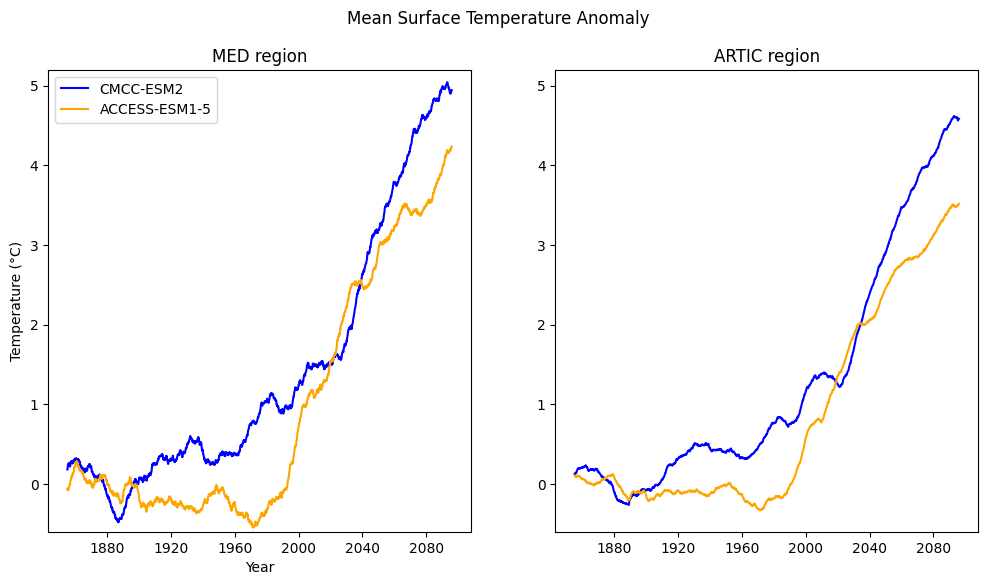

In [32]:

fig = plt.figure(1, figsize=[12,6])
fig.suptitle("Mean Surface Temperature Anomaly")

ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)

ax1.plot(ds_med["time"], ds_med[var], color = "blue")
ax1.plot(ds_med2["time"], ds_med2[var], color = "orange")

ax2.plot(ds_art["time"], ds_art[var], color = "blue")
ax2.plot(ds_art2["time"], ds_art2[var], color = "orange")

ax1.legend(["CMCC-ESM2","ACCESS-ESM1-5"])
ax1.set_xlabel("Year")
ax1.set_ylabel("Temperature (°C)")

ax1.set_ylim(-0.6,5.2)
ax2.set_ylim(-0.6,5.2)

ax1.set_title("MED region")
ax2.set_title("ARTIC region")

Despite some uncertainties about the magnitude, we have seen that both the models represent a clear warming trend for the 21st century, according to the SSP2-4.5 scenario.

# Explore HadISST Sea Surface Temperatures

Let's now explore some (quasi)observational dataset about SST, to compute some simple statistics and anomalies.
Also, we will see how SST anomalies located in some parts of the ocean drive temperature anomalies elsewhere.

In [33]:
file = 'HadISST_sst_new.nc'
ds_sst = xr.load_dataset(path+file)
ds_sst

<xarray.Dataset> Size: 481MB
Dimensions:    (time: 1857, nv: 2, latitude: 180, longitude: 360)
Coordinates:
  * time       (time) datetime64[ns] 15kB 1870-01-16T11:59:59.505615234 ... 2...
  * latitude   (latitude) float32 720B 89.5 88.5 87.5 86.5 ... -87.5 -88.5 -89.5
  * longitude  (longitude) float32 1kB -179.5 -178.5 -177.5 ... 178.5 179.5
Dimensions without coordinates: nv
Data variables:
    time_bnds  (time, nv) float32 15kB 0.0 31.0 31.0 ... 5.649e+04 5.652e+04
    sst        (time, latitude, longitude) float32 481MB -1e+03 -1e+03 ... nan
Attributes:
    Title:                      Monthly version of HadISST sea surface temper...
    description:                HadISST 1.1 monthly average sea surface tempe...
    institution:                Met Office Hadley Centre
    source:                     HadISST
    reference:                  Rayner, N. A., Parker, D. E., Horton, E. B., ...
    Conventions:                CF-1.0
    history:                    4/11/2024 converted to netcdf from pp format
    supplementary_information:  Updates and supplementary information will be...
    comment:                    Data restrictions: for academic research use ...

In [34]:
ds_sst = ds_sst.rename(longitude = "lon")
ds_sst = ds_sst.rename(latitude = "lat")

What we see here represented with values of -1000 is actually ICE extent

In [35]:
ds_sst["sst"] = ds_sst.sst.where(ds_sst.sst != -1000)

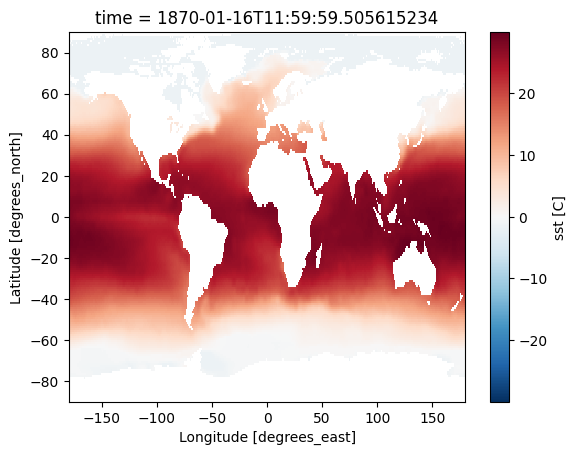

In [36]:
ds_sst.sst.isel(time = 0).plot()

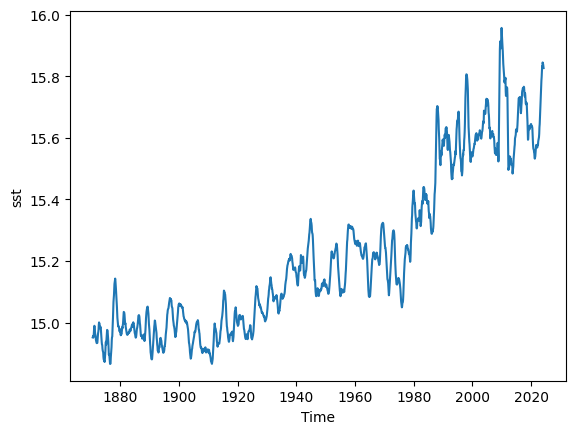

In [37]:
ds_sst.sst.sel(lat = slice(80, -80)).mean(dim = ["lat", "lon"]).rolling(time= 12, center = True).mean().plot()

### Calculate the Nino3.4 index. 

ENSO (El Nino Southern Oscillation) is a phenomenon of intrinsic climatic variability that emerges in the tropical Pacific Ocean. We can describe this phenomenon using several indeces that account for the monthly climatic anomaly in different geographical areas of the Tropical Pacific Ocean.

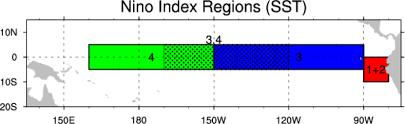

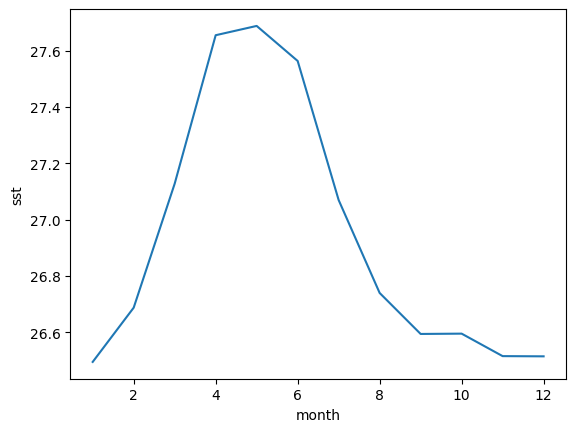

In [38]:
pixel_area = get_cell_area(ds_sst.sst)

n34_clim = ds_sst.sst.sel(lat = slice(5, -5), lon = slice(-170, -120)).groupby('time.month').mean('time').weighted(pixel_area).mean(["lat", "lon"])

n34_clim.plot()


In [39]:
nino34 = (ds_sst.sst.sel(lat = slice(5, -5), lon = slice(-170, -120)).weighted(pixel_area).mean(["lat", "lon"]).groupby('time.month') - n34_clim).rolling(time = 5, center = True).mean()
nino34

<xarray.DataArray 'sst' (time: 1857)> Size: 15kB
array([        nan,         nan, -0.92613968, ...,  0.26790142,
               nan,         nan])
Coordinates:
  * time     (time) datetime64[ns] 15kB 1870-01-16T11:59:59.505615234 ... 202...
    month    (time) int64 15kB 1 2 3 4 5 6 7 8 9 10 11 ... 12 1 2 3 4 5 6 7 8 9

Text(0, 0.5, 'Temperature (°C)')

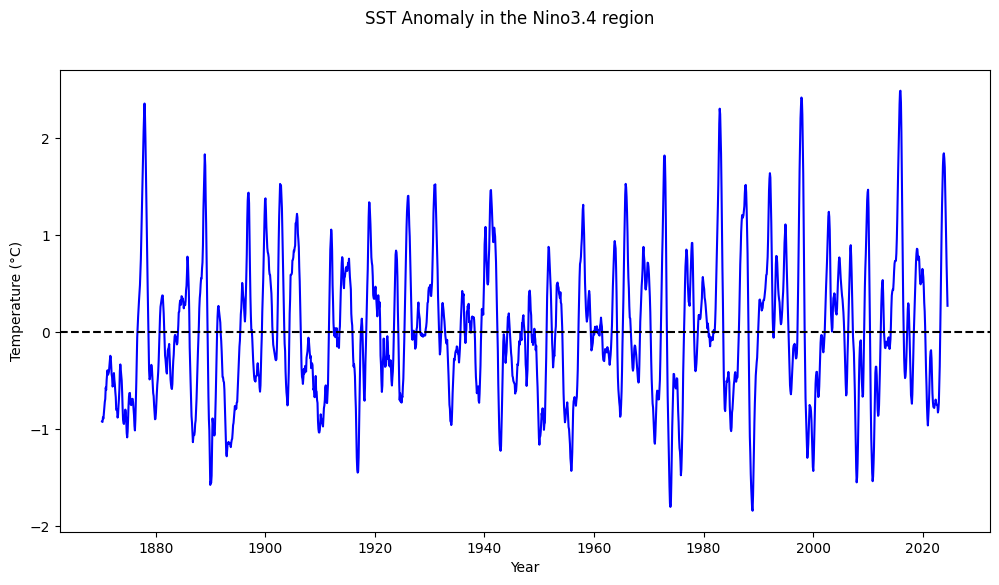

In [40]:
fig = plt.figure(1, figsize=[12,6])
fig.suptitle("SST Anomaly in the Nino3.4 region")

ax1 = plt.subplot(1, 1, 1)

ax1.plot(nino34["time"], nino34, color = "blue")
ax1.axhline(0, color = "black", linestyle = "--")
ax1.set_xlabel("Year")
ax1.set_ylabel("Temperature (°C)")


We can identify the strongest El Nino and La Nina events

In [41]:
nino34[nino34 > 1.5].time

<xarray.DataArray 'time' (time: 58)> Size: 464B
array(['1877-08-16T12:00:00.000000000', '1877-09-16T00:00:00.000000000',
       '1877-10-16T12:00:00.000000000', '1877-11-16T00:00:00.000000000',
       '1877-12-16T12:00:00.000000000', '1878-01-16T12:00:00.000000000',
       '1878-02-15T00:00:00.000000000', '1878-03-16T12:00:00.000000000',
       '1888-11-16T00:00:00.000000000', '1888-12-16T12:00:00.000000000',
       '1889-01-16T12:00:00.000000000', '1902-09-16T00:00:00.000000000',
       '1902-11-16T00:00:00.000000000', '1930-11-16T00:00:00.000000000',
       '1930-12-16T12:00:00.000000000', '1931-01-16T12:00:00.000000000',
       '1965-10-16T12:00:00.000000000', '1972-09-16T00:00:00.000000000',
       '1972-10-16T12:00:00.000000000', '1972-11-16T00:00:00.000000000',
       '1972-12-16T12:00:00.000000000', '1973-01-16T12:00:00.000000000',
       '1982-09-16T00:00:00.000000000', '1982-10-16T12:00:00.000000000',
       '1982-11-16T00:00:00.000000000', '1982-12-16T12:00:00.000000000',
       '1983-01-16T12:00:00.000000000', '1983-02-15T00:00:00.000000000',
       '1983-03-16T12:00:00.000000000', '1987-08-16T12:00:00.000000000',
       '1987-09-16T00:00:00.000000000', '1992-01-16T12:00:00.000000000',
       '1992-02-15T12:00:00.000000000', '1992-03-16T12:00:00.000000000',
       '1997-07-16T12:00:00.000000000', '1997-08-16T12:00:00.000000000',
       '1997-09-16T00:00:00.000000000', '1997-10-16T12:00:00.000000000',
       '1997-11-16T00:00:00.000000000', '1997-12-16T12:00:00.000000000',
       '1998-01-16T12:00:00.000000000', '1998-02-15T00:00:00.000000000',
       '1998-03-16T12:00:00.000000000', '2015-07-16T12:00:00.000000000',
       '2015-08-16T12:00:00.000000000', '2015-09-16T00:00:00.000000000',
       '2015-10-16T12:00:00.000000000', '2015-11-16T00:00:00.000000000',
       '2015-12-16T12:00:00.000000000', '2016-01-16T12:00:00.000000000',
       '2016-02-15T12:00:00.000000000', '2016-03-16T12:00:00.000000000',
       '2023-08-16T12:00:00.000000000', '2023-09-16T00:00:00.000000000',
       '2023-10-16T12:00:00.000000000', '2023-11-16T00:00:00.000000000',
       '2023-12-16T12:00:00.000000000', '2024-01-16T12:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 464B 1877-08-16T12:00:00 ... 2024-01-16T12...
    month    (time) int64 464B 8 9 10 11 12 1 2 3 11 12 ... 1 2 3 8 9 10 11 12 1

In [42]:
sst_clim = ds_sst.sst.groupby('time.month').mean('time')
sst_anom = (ds_sst.sst.groupby('time.month') - sst_clim).rolling(time = 5, center = True).mean()

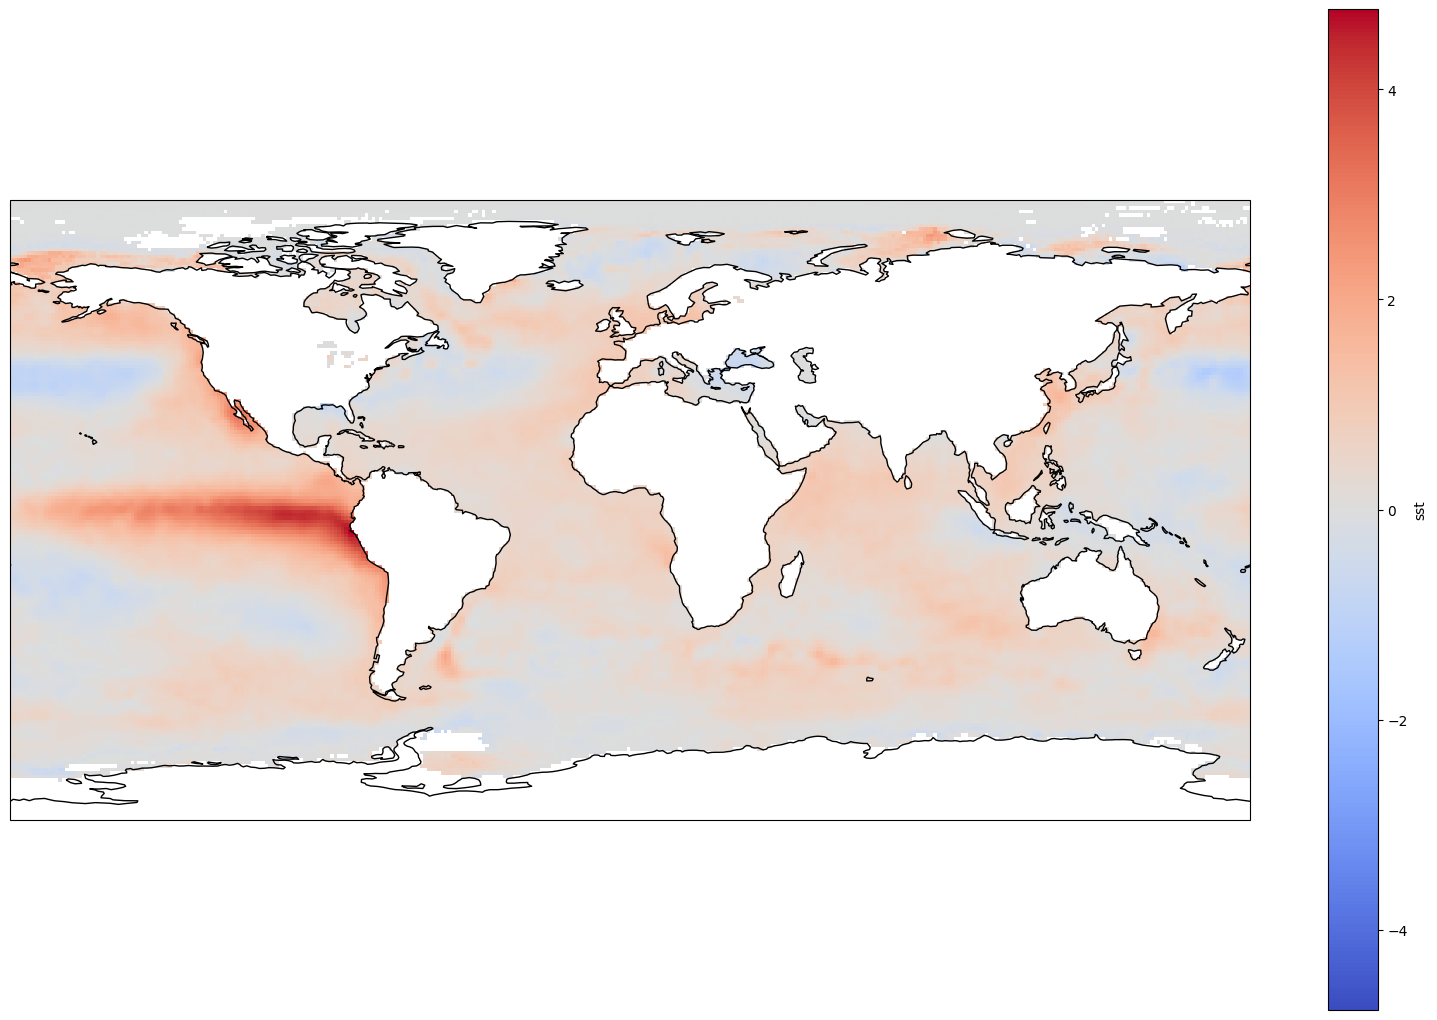

In [43]:
fig = plt.figure(1, figsize=[20,13])

# Set the projection to use for plotting
ax = plt.subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.coastlines()


# Pass ax as an argument when plotting. Here we assume data is in the same coordinate reference system than the projection chosen for plotting
# isel allows to select by indices instead of the time values
#ds[var].sel(time='2010-01').plot.pcolormesh(ax=ax, cmap='coolwarm')
lons = sst_anom.lon
lats = sst_anom.lat

#map = ax.pcolormesh(lons, lats, ds[var][0])
#map = ax.pcolormesh(lons, lats, ds[var].sel(time='2010-08').mean("time"))

sst_anom.sel(time = slice("1997-07","1998-02")).mean("time").plot.pcolormesh(ax=ax, cmap='coolwarm')